# Importing Libraries

In [ ]:
import os
import warnings
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

warnings.filterwarnings("ignore")

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
model_name = "deepseek-r1-distill-llama-70b"
# emb_model = "togethercomputer/m2-bert-80M-32k-retrieval"
emb_model = "sentence-transformers/all-mpnet-base-v2"
embedding_function = HuggingFaceEmbeddings(model_name=emb_model)

llm = ChatGroq(
    groq_api_key=GROQ_API_KEY,
    model=model_name,
)

# Langgraph Models

In [2]:
from typing import Annotated, TypedDict, Optional
from pydantic import BaseModel, Field

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages

class State(BaseModel):
    messages: Annotated[list, add_messages]

In [ ]:
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

@tool
def get_weather(location: str):
    """Returns a weather of a particular location."""
    if location.lower() in ['bengaluru', 'mysuru']:
        return "It is 15 degrees Celsius and cloudy."
    return "It is 30 degrees Celsius and sunny."

@tool
def broken_api(location: str):
    """Returns a weather of a particular location."""
    return f"Currently no weather data available for {location}. Please try again later."


tools = [get_weather, broken_api]

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state.messages)]}

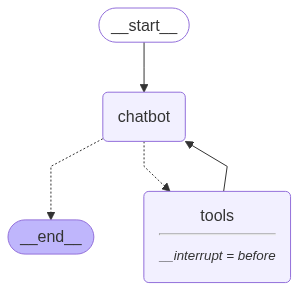

In [4]:
checkpointer = MemorySaver()

workflow = StateGraph(State)


workflow.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
workflow.add_node('tools', tool_node)

workflow.add_conditional_edges("chatbot", tools_condition)

workflow.add_edge("tools", "chatbot")

workflow.set_entry_point("chatbot")

graph = workflow.compile(checkpointer=checkpointer, interrupt_before=['tools'])

graph

In [5]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}

input_message = HumanMessage(content="Hello, I am SSH")

res = graph.invoke({"messages": input_message}, config=config)
res

{'messages': [HumanMessage(content='Hello, I am SSH', additional_kwargs={}, response_metadata={}, id='86732c03-18ad-4422-b313-a579499638e7'),
  AIMessage(content="It seems like you might be trying to use one of the tools provided. Could you please specify which function you'd like to use and provide the required location? For example, you can ask me to call `get_weather` or `broken_api` with a specific location.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 231, 'prompt_tokens': 165, 'total_tokens': 396, 'completion_time': 1.037724466, 'prompt_time': 0.024057843, 'queue_time': 0.049420456, 'total_time': 1.061782309}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--d6f81ff6-7d6d-4c60-9af4-9077b388bce6-0', usage_metadata={'input_tokens': 165, 'output_tokens': 231, 'total_tokens': 396})]}

In [6]:
config = {"configurable": {"thread_id": "2"}}

res2 = graph.invoke(
    {"messages": HumanMessage(content="Sorry, did I already introduce myself")},
    config=config
)
res2

{'messages': [HumanMessage(content='Sorry, did I already introduce myself', additional_kwargs={}, response_metadata={}, id='d5e094ea-ee60-4553-903e-caa62f975da3'),
  AIMessage(content='Sure! Here are the tools available to assist with your query:\n\n1. **get_weather**: This function returns the weather for a specific location.\n   - Parameters: `location` (string, required)\n   - Example call: `{"name": "get_weather", "arguments": {"location": "London"}}`\n\n2. **broken_api**: This function is intended to return the weather for a specific location but might be unreliable.\n   - Parameters: `location` (string, required)\n   - Example call: `{"name": "broken_api", "arguments": {"location": "Paris"}}`\n\nFeel free to ask for more details or use any of these functions as needed!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 316, 'prompt_tokens': 167, 'total_tokens': 483, 'completion_time': 1.330227901, 'prompt_time': 0.024067133, 'queue_time': 0.047343417,

In [7]:
config = {"configurable": {"thread_id": "1"}}

res3 = graph.invoke(
    {"messages": HumanMessage(content="Sorry, did I already introduce myself")},
    config=config
)
res3

{'messages': [HumanMessage(content='Hello, I am SSH', additional_kwargs={}, response_metadata={}, id='86732c03-18ad-4422-b313-a579499638e7'),
  AIMessage(content="It seems like you might be trying to use one of the tools provided. Could you please specify which function you'd like to use and provide the required location? For example, you can ask me to call `get_weather` or `broken_api` with a specific location.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 231, 'prompt_tokens': 165, 'total_tokens': 396, 'completion_time': 1.037724466, 'prompt_time': 0.024057843, 'queue_time': 0.049420456, 'total_time': 1.061782309}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--d6f81ff6-7d6d-4c60-9af4-9077b388bce6-0', usage_metadata={'input_tokens': 165, 'output_tokens': 231, 'total_tokens': 396}),
  HumanMessage(content='Sorry, did I already introduce myself', additional_kwar

In [8]:
snapshot = graph.get_state(config)

snapshot.next

()

In [9]:
snapshot.values

{'messages': [HumanMessage(content='Hello, I am SSH', additional_kwargs={}, response_metadata={}, id='86732c03-18ad-4422-b313-a579499638e7'),
  AIMessage(content="It seems like you might be trying to use one of the tools provided. Could you please specify which function you'd like to use and provide the required location? For example, you can ask me to call `get_weather` or `broken_api` with a specific location.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 231, 'prompt_tokens': 165, 'total_tokens': 396, 'completion_time': 1.037724466, 'prompt_time': 0.024057843, 'queue_time': 0.049420456, 'total_time': 1.061782309}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--d6f81ff6-7d6d-4c60-9af4-9077b388bce6-0', usage_metadata={'input_tokens': 165, 'output_tokens': 231, 'total_tokens': 396}),
  HumanMessage(content='Sorry, did I already introduce myself', additional_kwar

In [10]:
graph.invoke(None, config=config)

{'messages': [HumanMessage(content='Hello, I am SSH', additional_kwargs={}, response_metadata={}, id='86732c03-18ad-4422-b313-a579499638e7'),
  AIMessage(content="It seems like you might be trying to use one of the tools provided. Could you please specify which function you'd like to use and provide the required location? For example, you can ask me to call `get_weather` or `broken_api` with a specific location.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 231, 'prompt_tokens': 165, 'total_tokens': 396, 'completion_time': 1.037724466, 'prompt_time': 0.024057843, 'queue_time': 0.049420456, 'total_time': 1.061782309}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--d6f81ff6-7d6d-4c60-9af4-9077b388bce6-0', usage_metadata={'input_tokens': 165, 'output_tokens': 231, 'total_tokens': 396}),
  HumanMessage(content='Sorry, did I already introduce myself', additional_kwar

In [11]:
config = {"configurable": {"thread_id": "3"}}

res3 = graph.invoke(
    {"messages": HumanMessage(content="How is the weather in Bengaluru??")},
    config=config
)
res3

{'messages': [HumanMessage(content='How is the weather in Bengaluru??', additional_kwargs={}, response_metadata={}, id='cbae0167-2f21-4575-ad98-00bd8e619096'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'kc3ka9vdw', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 168, 'total_tokens': 304, 'completion_time': 0.555419552, 'prompt_time': 0.024124015, 'queue_time': 0.043395485, 'total_time': 0.579543567}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7bba144a-2ddd-4046-a186-55f6f76ec26f-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'kc3ka9vdw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 136, 'total_tokens': 304})]}

In [12]:
snapshot = graph.get_state(config)

snapshot.next

('tools',)

In [13]:
graph.invoke(None, config=config)

{'messages': [HumanMessage(content='How is the weather in Bengaluru??', additional_kwargs={}, response_metadata={}, id='cbae0167-2f21-4575-ad98-00bd8e619096'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'kc3ka9vdw', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 168, 'total_tokens': 304, 'completion_time': 0.555419552, 'prompt_time': 0.024124015, 'queue_time': 0.043395485, 'total_time': 0.579543567}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7bba144a-2ddd-4046-a186-55f6f76ec26f-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'kc3ka9vdw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 136, 'total_tokens': 304}),
  ToolMessage(content='It is 15 degrees Celsius and cloudy.',

# TimeTravel

In [14]:
config = {"configurable": {"thread_id": "4"}}

res3 = graph.invoke(
    {"messages": HumanMessage(content="How is the weather in Bengaluru??")},
    config=config
)
res3

{'messages': [HumanMessage(content='How is the weather in Bengaluru??', additional_kwargs={}, response_metadata={}, id='656a386e-0e22-40ea-a8da-81836c28681b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v7x9fryd9', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 238, 'prompt_tokens': 168, 'total_tokens': 406, 'completion_time': 0.908823639, 'prompt_time': 0.024217093, 'queue_time': 0.043595197, 'total_time': 0.933040732}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7be56c4c-2ae3-43ac-aaf4-31ae2cef3c4c-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'v7x9fryd9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 238, 'total_tokens': 406})]}

In [15]:
snapshot = graph.get_state(config)
existing_message = snapshot.values['messages'][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_weather (v7x9fryd9)
 Call ID: v7x9fryd9
  Args:
    location: Bengaluru


In [16]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

answer = "It is only 5 degree Celsius warm today."

new_messages = [
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]['id']),
    AIMessage(content=answer)
]

graph.update_state(config, {"messages": new_messages})

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1f083d1a-cb65-65a6-8002-b8518c702203'}}

In [17]:
print((graph.get_state(config).values['messages']))

[HumanMessage(content='How is the weather in Bengaluru??', additional_kwargs={}, response_metadata={}, id='656a386e-0e22-40ea-a8da-81836c28681b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v7x9fryd9', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 238, 'prompt_tokens': 168, 'total_tokens': 406, 'completion_time': 0.908823639, 'prompt_time': 0.024217093, 'queue_time': 0.043595197, 'total_time': 0.933040732}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7be56c4c-2ae3-43ac-aaf4-31ae2cef3c4c-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'v7x9fryd9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 238, 'total_tokens': 406}), ToolMessage(content='It is only 5 degree Celsius warm today.', id='2d57b516-

In [18]:
graph.invoke({"messages": HumanMessage(content="How warm was it again?")}, config=config)

{'messages': [HumanMessage(content='How is the weather in Bengaluru??', additional_kwargs={}, response_metadata={}, id='656a386e-0e22-40ea-a8da-81836c28681b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v7x9fryd9', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 238, 'prompt_tokens': 168, 'total_tokens': 406, 'completion_time': 0.908823639, 'prompt_time': 0.024217093, 'queue_time': 0.043595197, 'total_time': 0.933040732}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7be56c4c-2ae3-43ac-aaf4-31ae2cef3c4c-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'v7x9fryd9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 238, 'total_tokens': 406}),
  ToolMessage(content='It is only 5 degree Celsius warm today

In [19]:
graph.invoke(None, config=config)


{'messages': [HumanMessage(content='How is the weather in Bengaluru??', additional_kwargs={}, response_metadata={}, id='656a386e-0e22-40ea-a8da-81836c28681b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v7x9fryd9', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 238, 'prompt_tokens': 168, 'total_tokens': 406, 'completion_time': 0.908823639, 'prompt_time': 0.024217093, 'queue_time': 0.043595197, 'total_time': 0.933040732}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7be56c4c-2ae3-43ac-aaf4-31ae2cef3c4c-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'v7x9fryd9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 238, 'total_tokens': 406}),
  ToolMessage(content='It is only 5 degree Celsius warm today

# Replay

In [20]:
all_checkpoints = []

for state in graph.get_state_history(config=config):
    all_checkpoints.append(state)

all_checkpoints

[StateSnapshot(values={'messages': [HumanMessage(content='How is the weather in Bengaluru??', additional_kwargs={}, response_metadata={}, id='656a386e-0e22-40ea-a8da-81836c28681b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v7x9fryd9', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 238, 'prompt_tokens': 168, 'total_tokens': 406, 'completion_time': 0.908823639, 'prompt_time': 0.024217093, 'queue_time': 0.043595197, 'total_time': 0.933040732}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7be56c4c-2ae3-43ac-aaf4-31ae2cef3c4c-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'v7x9fryd9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 238, 'total_tokens': 406}), ToolMessage(content='It is only 5 degree 

In [21]:
to_replay = all_checkpoints[4]
to_replay.values

{'messages': [HumanMessage(content='How is the weather in Bengaluru??', additional_kwargs={}, response_metadata={}, id='656a386e-0e22-40ea-a8da-81836c28681b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v7x9fryd9', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 238, 'prompt_tokens': 168, 'total_tokens': 406, 'completion_time': 0.908823639, 'prompt_time': 0.024217093, 'queue_time': 0.043595197, 'total_time': 0.933040732}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7be56c4c-2ae3-43ac-aaf4-31ae2cef3c4c-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'v7x9fryd9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 238, 'total_tokens': 406}),
  ToolMessage(content='It is only 5 degree Celsius warm today

In [22]:
to_replay.next

('__start__',)

In [23]:
to_replay.config

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1f083d1a-cba2-6790-8003-d23ce486c013'}}

In [29]:
graph.invoke(None, config=to_replay.config)

{'messages': [HumanMessage(content='How is the weather in Bengaluru??', additional_kwargs={}, response_metadata={}, id='656a386e-0e22-40ea-a8da-81836c28681b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v7x9fryd9', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 238, 'prompt_tokens': 168, 'total_tokens': 406, 'completion_time': 0.908823639, 'prompt_time': 0.024217093, 'queue_time': 0.043595197, 'total_time': 0.933040732}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7be56c4c-2ae3-43ac-aaf4-31ae2cef3c4c-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'v7x9fryd9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 238, 'total_tokens': 406}),
  ToolMessage(content='It is only 5 degree Celsius warm today

# Branching off past state

In [30]:
last_message = to_replay.values['messages'][-1]
last_message.tool_calls

[]

In [ ]:
last_message.tool_calls[0]['name'] = "broken_api"
last_message.tool_calls

In [ ]:
branch_config = graph.update_state(
    to_replay.config,
    {"messages": [last_message]}
)

branch_config

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0835a2-fdbc-6dcf-8002-2c0efff42865'}}

In [ ]:
graph.invoke(None, branch_config)

{'messages': [HumanMessage(content='How is the weather in Bengaluru??', additional_kwargs={}, response_metadata={}, id='6c218342-7cd8-492b-9591-ea4964f0cc75'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'yk5p7n2jh', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 142, 'prompt_tokens': 168, 'total_tokens': 310, 'completion_time': 0.57880423, 'prompt_time': 0.024114166, 'queue_time': 0.044675844, 'total_time': 0.602918396}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--463f98a0-001d-40b7-abde-50dc4a16d402-0', tool_calls=[{'name': 'broken_api', 'args': {'location': 'Bengaluru'}, 'id': 'yk5p7n2jh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 142, 'total_tokens': 310}),
  ToolMessage(content='Currently no weather data available for 

In [ ]:
graph.invoke(None, branch_config)

{'messages': [HumanMessage(content='How is the weather in Bengaluru??', additional_kwargs={}, response_metadata={}, id='6c218342-7cd8-492b-9591-ea4964f0cc75'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'yk5p7n2jh', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 142, 'prompt_tokens': 168, 'total_tokens': 310, 'completion_time': 0.57880423, 'prompt_time': 0.024114166, 'queue_time': 0.044675844, 'total_time': 0.602918396}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--463f98a0-001d-40b7-abde-50dc4a16d402-0', tool_calls=[{'name': 'broken_api', 'args': {'location': 'Bengaluru'}, 'id': 'yk5p7n2jh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 142, 'total_tokens': 310}),
  ToolMessage(content='Currently no weather data available for 

# Wait for user input

In [31]:
from typing import Annotated

class State(BaseModel):
    messages: Annotated[list, add_messages]
    ask_human: Optional[bool] = False


In [32]:
from langchain_core.tools import tool

@tool
def request_assistance():
    """
    Escalate the conversation to an expert. Use this if you are unable to assist \
        directly or if the user requires support beyond your permissions. 
    """
    return ""

tools = [get_weather]

llm_with_tools = llm.bind_tools(tools + [request_assistance])

def chatbot(state: State):
    response = llm_with_tools.invoke(state.messages)
    ask_human = False
    if response.tool_calls and response.tool_calls[0]['name'] == "request_assistance":
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


In [33]:
from langchain_core.messages import AIMessage, HumanMessage

def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]['id']
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state.messages[-1], ToolMessage):
        new_messages.append(
            create_response(
                "Plan a trip 3 months before and dont carry a Real Madrid shirt with you",
                state.messages[-1]
            )
        )
    return {"messages": new_messages, "ask_human": False}


def select_next_node(state: State):
    if state.ask_human:
        return "human"
    return tools_condition(state)

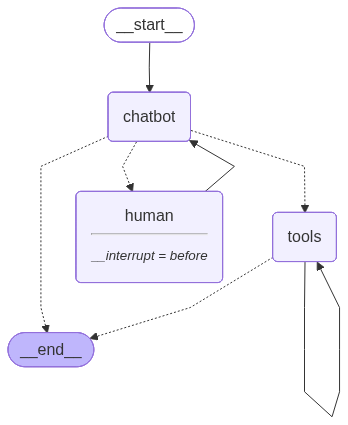

In [34]:
workflow_v2 = StateGraph(State)

workflow_v2.add_node("chatbot", chatbot)
workflow_v2.add_node("tools", ToolNode(tools=tools))


workflow_v2.add_node("human", human_node)


workflow_v2.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

workflow_v2.add_edge("tools", "tools")
workflow_v2.add_edge("human", "chatbot")
workflow_v2.set_entry_point("chatbot")

checkpointer = MemorySaver()

graph = workflow_v2.compile(checkpointer=checkpointer, interrupt_before=["human"],)

graph

In [35]:
config = {"configurable":{"thread_id": "50"}}

input_message = HumanMessage(
    content="I need some expert advice on how to plan a trip to barcelona"
)

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='I need some expert advice on how to plan a trip to barcelona', additional_kwargs={}, response_metadata={}, id='a69d6ded-a504-4edc-bbc3-1d990be119e7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bzqhbc1cw', 'function': {'arguments': '{}', 'name': 'request_assistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 186, 'total_tokens': 246, 'completion_time': 0.256597352, 'prompt_time': 0.03278764, 'queue_time': 0.04375825, 'total_time': 0.289384992}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6c975d1e-e8ab-478a-b30e-e9d181c21e7f-0', tool_calls=[{'name': 'request_assistance', 'args': {}, 'id': 'bzqhbc1cw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 186, 'output_tokens': 60, 'total_tokens': 246})],
 'ask_human': True}

In [36]:
graph.invoke(None, config=config)

{'messages': [HumanMessage(content='I need some expert advice on how to plan a trip to barcelona', additional_kwargs={}, response_metadata={}, id='a69d6ded-a504-4edc-bbc3-1d990be119e7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bzqhbc1cw', 'function': {'arguments': '{}', 'name': 'request_assistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 186, 'total_tokens': 246, 'completion_time': 0.256597352, 'prompt_time': 0.03278764, 'queue_time': 0.04375825, 'total_time': 0.289384992}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6c975d1e-e8ab-478a-b30e-e9d181c21e7f-0', tool_calls=[{'name': 'request_assistance', 'args': {}, 'id': 'bzqhbc1cw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 186, 'output_tokens': 60, 'total_tokens': 246}),
  ToolMessage(content='Plan a trip 3 months before and dont carry a R

# Human in the loop - Interrupt + Command

In [37]:
from typing import Optional, Literal

from langgraph.graph import END, StateGraph
from langgraph.types import Command

from pydantic import BaseModel

class InputState(BaseModel):
    string_value: str
    numeric_value: int

In [38]:
def modify_state(input_state: InputState) -> InputState:
    input_state.string_value += "A"
    input_state.numeric_value += 1
    return input_state


def branch_A(state: InputState) -> Command[Literal["branch_B"]]:
    print(f"branch_B: Current State: {state}")
    new_state = modify_state(state)
    print(f"branch_A: Updated State: {new_state}")
    return Command(goto="branch_B", update=new_state)

def branch_B(state: InputState) -> Command[Literal["branch_C"]]:
    print(f"branch_b: Current State: {state}")
    new_state = modify_state(state)
    print(f"branch_b: Updated State: {new_state}")
    return Command(goto="branch_C", update=new_state)

def branch_C(state: InputState) -> Command[Literal[END]]:
    print(f"branch_C: Current State: {state}")
    new_state = modify_state(state)
    print(f"branch_C: updated State: {new_state}")
    return Command(goto=END, update=new_state)


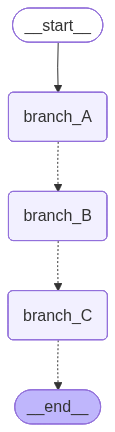

In [39]:
graph = StateGraph(InputState)

graph.add_node("branch_A", branch_A)
graph.add_node("branch_B", branch_B)
graph.add_node("branch_C", branch_C)

graph.set_entry_point("branch_A")

runnable = graph.compile()
runnable

In [40]:
initial_state = {"string_value": "Hello", "numeric_value": 0}
final_state = runnable.invoke(initial_state)
final_state

branch_B: Current State: string_value='Hello' numeric_value=0
branch_A: Updated State: string_value='HelloA' numeric_value=1
branch_b: Current State: string_value='HelloA' numeric_value=1
branch_b: Updated State: string_value='HelloAA' numeric_value=2
branch_C: Current State: string_value='HelloAA' numeric_value=2
branch_C: updated State: string_value='HelloAAA' numeric_value=3


{'string_value': 'HelloAAA', 'numeric_value': 3}

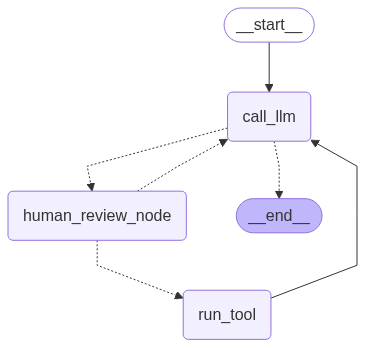

In [41]:
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

@tool

def weather_search(city: str):
    """Search for the weather in a specific city"""

    print("--------------------------------------------------------")
    print(f"Searching for: {city}")
    print("--------------------------------------------------------")
    return "Sunny!"


def call_llm(state: MessagesState):
    return {"messages": [llm.invoke(state['messages'])]}


def human_review_node(state: MessagesState) -> Command[Literal["call_llm", "run_tool"]]:
    last_message = state['messages'][-1]
    tool_call = last_message.tool_calls[-1]

    human_review = interrupt(
        {
            "question": "Is this correct?",
            "tool_call": tool_call
        }
    )

    print(f"Human review values: {human_review}")

    review_action = human_review['action']
    review_data = human_review.get("data")

    if review_action == "continue":
        return Command(goto="run_tool")
    
    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id":tool_call['id'],
                    "name": tool_call['name'],
                    "args": review_data
                }
            ],
            "id": last_message.id
        }
        return Command(goto="run_tool", update={"messages": [updated_message]})
    

def route_after_llm(state: MessagesState) -> Literal[END, "human_review_node"]:
    if len(state['messages'][-1].tool_calls) == 0:
        return END
    return "human_review_node"


builder = StateGraph(MessagesState)

builder.add_node("call_llm", call_llm)
builder.add_node("run_tool", ToolNode(tools=[weather_search]))
builder.add_node("human_review_node", human_review_node)


builder.add_conditional_edges("call_llm", route_after_llm)

builder.add_edge("run_tool", "call_llm")

builder.set_entry_point("call_llm")


memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

graph



In [42]:
initial_input = {"messages": [HumanMessage(content="How is the weather in Bengaluru?")]}
config = {"configurable": {"thread_id": "5"}}

first_result = graph.invoke(initial_input, config=config, stream_mode="updates")
first_result

[{'call_llm': {'messages': [AIMessage(content="<think>\n\n</think>\n\nHi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 11, 'total_tokens': 45, 'completion_time': 0.188732692, 'prompt_time': 0.010248862, 'queue_time': 0.049410467, 'total_time': 0.198981554}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--0546a586-0d53-495a-81d1-5cd95f8a74cb-0', usage_metadata={'input_tokens': 11, 'output_tokens': 34, 'total_tokens': 45})]}}]

In [43]:
print(graph.get_state(config).next)

()


In [44]:
graph.invoke(Command(resume={"action": "continue"}), config=config)

{'messages': [HumanMessage(content='How is the weather in Bengaluru?', additional_kwargs={}, response_metadata={}, id='76ed2f15-822b-472c-b7b6-472995073c43'),
  AIMessage(content="<think>\n\n</think>\n\nHi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 11, 'total_tokens': 45, 'completion_time': 0.188732692, 'prompt_time': 0.010248862, 'queue_time': 0.049410467, 'total_time': 0.198981554}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--0546a586-0d53-495a-81d1-5cd95f8a74cb-0', usage_metadata={'input_tokens': 11, 'output_tokens': 34, 'total_tokens': 45})]}

In [45]:
config = {"configurable": {"thread_id": "6"}}

graph.invoke(initial_input, config=config, stream_mode="updates")

[{'call_llm': {'messages': [AIMessage(content="<think>\n\n</think>\n\nHi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 11, 'total_tokens': 45, 'completion_time': 0.185102303, 'prompt_time': 0.01033513, 'queue_time': 0.049397509, 'total_time': 0.195437433}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--9b467fb3-1870-420f-be79-ffda194cce84-0', usage_metadata={'input_tokens': 11, 'output_tokens': 34, 'total_tokens': 45})]}}]

In [46]:
print(graph.get_state(config).next)

()


In [47]:
graph.invoke(Command(resume={"action": "update", "data": {"city": "Bengaluru"}}), config=config)

{'messages': [HumanMessage(content='How is the weather in Bengaluru?', additional_kwargs={}, response_metadata={}, id='76ed2f15-822b-472c-b7b6-472995073c43'),
  AIMessage(content="<think>\n\n</think>\n\nHi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 11, 'total_tokens': 45, 'completion_time': 0.185102303, 'prompt_time': 0.01033513, 'queue_time': 0.049397509, 'total_time': 0.195437433}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--9b467fb3-1870-420f-be79-ffda194cce84-0', usage_metadata={'input_tokens': 11, 'output_tokens': 34, 'total_tokens': 45})]}